<a href="https://colab.research.google.com/github/Tom-Jung/ML_Colab/blob/main/28_Transfer_Learning_exam(catsanddogs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pwd

/content


In [10]:
!ls -al

total 28
drwxr-xr-x 1 root root 4096 Mar 29 13:01 .
drwxr-xr-x 1 root root 4096 Mar 29 12:58 ..
drwxr-xr-x 4 root root 4096 Mar 23 14:21 .config
drwxr-xr-x 2 root root 4096 Mar 29 13:00 .ipynb_checkpoints
drwxr-xr-x 1 root root 4096 Mar 29 13:01 sample_data
drwxr-xr-x 2 root root 4096 Mar 29 13:01 test_image_dir


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
# 파일 다운로드

!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-03-29 13:03:03--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.119.128, 108.177.111.128, 108.177.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   229MB/s    in 0.3s    

2022-03-29 13:03:03 (229 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [13]:
import os
import shutil

if os.path.exists('/content/cats_and_dogs_filtered/'):    # 작업 디렉토리는 cats_and_dogs_filtered
    
    shutil.rmtree('/content/cats_and_dogs_filtered/')
    print('/content/cats_and_dogs_filtered/  is removed !!!')

In [14]:
# 압축파일 풀기

import zipfile

with zipfile.ZipFile('/content/cats_and_dogs_filtered.zip', 'r') as target_file:

    target_file.extractall('/content/cats_and_dogs_filtered/')

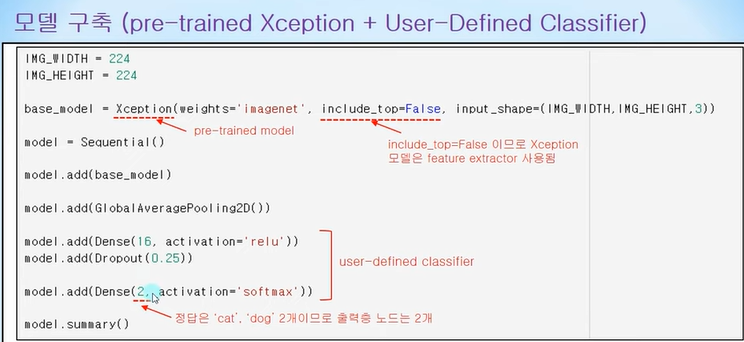

In [15]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [16]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH,IMG_HEIGHT,3))

base_model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                   

In [17]:
model = Sequential()

model.add(base_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 16)                32784     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 20,894,298
Trainable params: 20,839,770
Non-trainable params: 54,528
_______________________________________

In [18]:
# ImageDataGenerator 이용하여 데이터 불러옴

train_data_gen = ImageDataGenerator(rescale=1./255, 
                                    rotation_range=10, width_shift_range=0.1, 
                                    height_shift_range=0.1, shear_range=0.1, zoom_range=0.1)

test_data_gen = ImageDataGenerator(rescale=1./255)

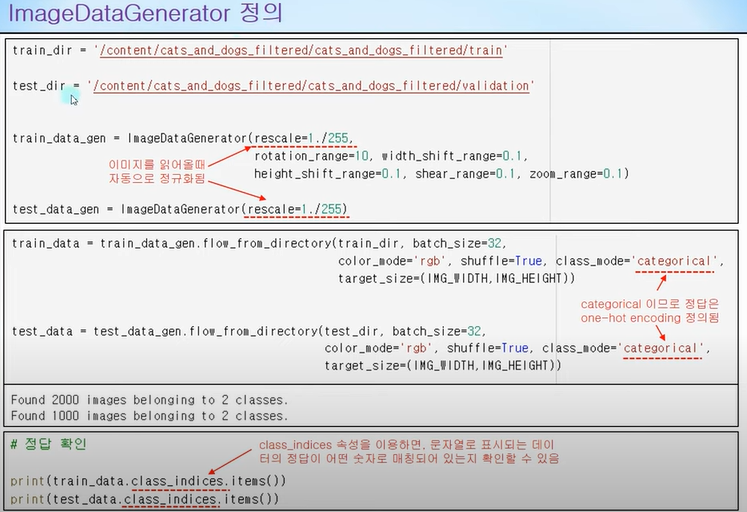

In [19]:
train_dir = '/content/cats_and_dogs_filtered/cats_and_dogs_filtered/train'

test_dir = '/content/cats_and_dogs_filtered/cats_and_dogs_filtered/validation'

In [20]:
train_data = train_data_gen.flow_from_directory(train_dir, batch_size=32, 
                                                color_mode='rgb', shuffle=True, class_mode='categorical',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT))


test_data = test_data_gen.flow_from_directory(test_dir, batch_size=32, 
                                              color_mode='rgb', shuffle=True, class_mode='categorical',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [21]:
# 정답 확인

print(train_data.class_indices.items())
print(test_data.class_indices.items())

print(len(train_data.classes))
print(len(test_data.classes))

print(train_data.num_classes)
print(test_data.num_classes)

dict_items([('cats', 0), ('dogs', 1)])
dict_items([('cats', 0), ('dogs', 1)])
2000
1000
2
2


In [22]:
# 모델 컴파일

model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['accuracy'])

In [23]:
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

save_file_name = './cats_and_dogs_filtered_Xception_Colab.h5'

checkpoint = ModelCheckpoint(save_file_name,       
                             monitor='val_loss',   
                             verbose=1,            
                             save_best_only=True,  
                             mode='auto'           
                            )

earlystopping = EarlyStopping(monitor='val_loss',  
                              patience=5,          
                             )


start_time = datetime.now()

hist = model.fit(train_data, epochs=30, 
                 validation_data=test_data,
                 callbacks=[checkpoint, earlystopping])

end_time = datetime.now()

print('elapsed time = ', end_time-start_time)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 0.4982 - accuracy: 0.8080
Epoch 1: val_loss improved from inf to 0.16727, saving model to ./cats_and_dogs_filtered_Xception_Colab.h5
63/63 [==============================] - 119s 2s/step - loss: 0.4982 - accuracy: 0.8080 - val_loss: 0.1673 - val_accuracy: 0.9750
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 0.2268 - accuracy: 0.9650
Epoch 2: val_loss improved from 0.16727 to 0.06688, saving model to ./cats_and_dogs_filtered_Xception_Colab.h5
63/63 [==============================] - 96s 2s/step - loss: 0.2268 - accuracy: 0.9650 - val_loss: 0.0669 - val_accuracy: 0.9830
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 0.1205 - accuracy: 0.9790
Epoch 3: val_loss improved from 0.06688 to 0.04888, saving model to ./cats_and_dogs_filtered_Xception_Colab.h5
63/63 [==============================] - 96s 2s/step - loss: 0.1205 - accuracy: 0.9790 - val_loss: 0.0489 - val_accuracy: 0.9830
E

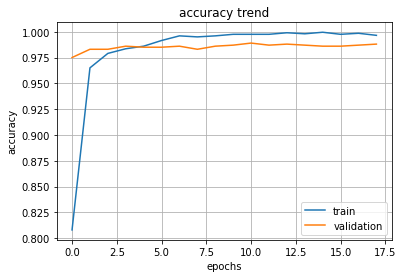

In [33]:
import matplotlib.pyplot as plt

plt.title('accuracy trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.legend(loc='best')
plt.show()

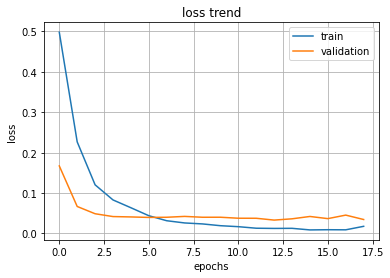

In [34]:
import matplotlib.pyplot as plt

plt.title('loss trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend(loc='best')
plt.show()

In [35]:
import os
import shutil

if os.path.exists('/content/test_image_dir/'):    
    
    shutil.rmtree('/content/test_image_dir/')
    print('/content/test_image_dir/  is removed !!!')

/content/test_image_dir/  is removed !!!


In [36]:
# 압축파일 풀기

import zipfile

with zipfile.ZipFile('/content/sample_data/test_image_dir.zip', 'r') as target_file:

    target_file.extractall('/content/test_image_dir/')

In [37]:
import cv2
import glob

test_img_list = []

test_img_name_list = glob.glob('test_image_dir/*')

for i in range(len(test_img_name_list)):

    src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(IMG_WIDTH, IMG_HEIGHT))

    dst_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    dst_img = dst_img / 255.0

    test_img_list.append(dst_img)

print(test_img_name_list)
print(len(test_img_list))

['test_image_dir/cat1.jpg', 'test_image_dir/cat3.jpg', 'test_image_dir/dog2.jpg', 'test_image_dir/cat2.jpg', 'test_image_dir/dog1.jpg', 'test_image_dir/dog3.jpg']
6


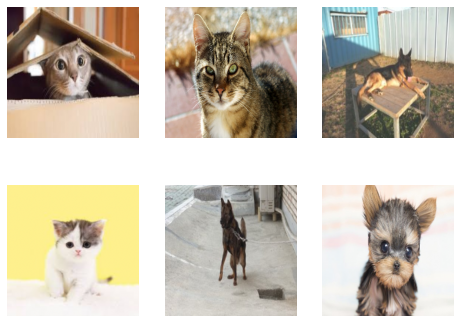

In [38]:
plt.figure(figsize=(8,6))

for i in range(len(test_img_list)):

    plt.subplot(2, 3, i+1)
    plt.axis('off')
    plt.imshow(test_img_list[i])

plt.show()

In [42]:
for i in range(len(test_img_list)):

    print(test_img_list[i].shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [43]:
# predict 수행하기 위해 batch 차원 추가
import numpy as np

print(np.array(test_img_list).shape)

(6, 224, 224, 3)


In [44]:
# predict 실행

class_name = [ 'cat', 'dog' ]  # ImageDataGenerator 에서 cat=0, dog=1

pred = model.predict(np.array(test_img_list))

print(pred.shape)
print(pred)

(6, 2)
[[9.9986172e-01 1.3821045e-04]
 [9.9916494e-01 8.3503372e-04]
 [2.0255512e-03 9.9797446e-01]
 [9.9335033e-01 6.6496804e-03]
 [4.3477261e-04 9.9956518e-01]
 [2.3825803e-01 7.6174200e-01]]


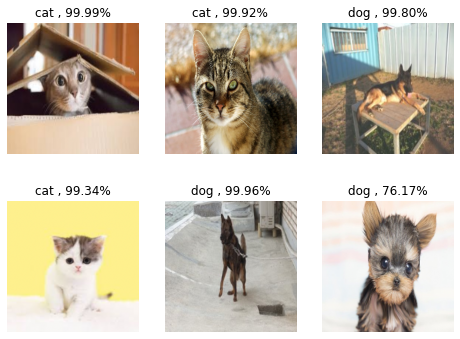

In [45]:
class_name = [ 'cat', 'dog' ]  # ImageDataGenerator 에서 cat=0, dog=1

plt.figure(figsize=(8,6))

for i in range(len(pred)):

    plt.subplot(2, 3, i+1)
    prediction = str(class_name[np.argmax(pred[i])])
    probility = '{0:0.2f}'.format(100*max(pred[i]))
    title_str = prediction + ' , ' + probility + '%'
    plt.axis('off')
    plt.title(title_str)
    plt.imshow(test_img_list[i])

plt.show()